In [60]:
# IMPORTS AND PARAMETERS
import threading, random, queue, functools, time
from collections import deque
import matplotlib.pyplot as plt

random.seed(9)
WE_pass_init = [False, False, True, False]
MAX_ITER = 5000
DEBUG = False
DEBUG_S = False
LIGHT_SWITCHING_INTERVAL = 120
print_lock = threading.Lock()

def m_print(*msg):
    with print_lock:
        print(*msg)

In [61]:
# EVENT SYSTEM
@functools.total_ordering
class Event:
    def __init__(self, time, f):
        self.time = time
        self.f = f

    def __eq__(self, other):
        return self.time == other.time

    def __lt__(self, other):
        return self.time < other.time

class Scheduler(threading.Thread):
    def __init__(self): 
        super().__init__()
        self.time = 0
        self.event_queue = queue.PriorityQueue()
        self.lock = threading.Lock()
        self.cv = threading.Condition()
        self.notified = {}
        
    def schedule(self, event, time):
        with self.lock:
            self.event_queue.put(Event(self.time + time, event))
    
    def run(self):
        while not (self.event_queue.empty() and Lane.all_lanes_clear()):
            next_event = self.event_queue.get()
            self.time = next_event.time
            if DEBUG or DEBUG_S:
                m_print(threading.get_ident(), '>>> time = %f' % self.time)
                m_print(next_event.f, next_event.time)
            # next_event.f()
            threading.Thread(target=next_event.f).start()
            # !!!! WAIT FOR EVERYTHING TO BE PROCESS BEFORE PROCEEDING
            with self.cv:
                while any(pending for pending in self.notified.values()):
                    if DEBUG or DEBUG_S:
                        m_print(threading.get_ident(), '>>> scheduler waiting...')
#                         m_print(self.notified)
                    self.notified[threading.get_ident()] = False
                    self.cv.notify()     
                    self.cv.wait()
            if DEBUG or DEBUG_S:
                m_print(threading.get_ident(), '>>> scheduler continues')
            self.notified = {}        
        print('DONE')
            
scheduler = Scheduler()

In [62]:
# ROAD MODEL
class Lane:
    
    @staticmethod 
    def all_lanes_clear():
        
        get_all_lanes = lambda i: i.incoming + (i.lanes if hasattr(i, 'lanes') else [])
            
        all_lanes = (
            get_all_lanes(peachtree_and_10th) + 
            get_all_lanes(peachtree_and_11th) +
            get_all_lanes(peachtree_and_12th) +
            get_all_lanes(peachtree_and_14th)
        )
        all_lanes.append(lane_13th_street)
        return all(len(lane.queue) == 0 for lane in all_lanes)

    def __init__(self, direction, capacity=20, intersection_name=''):
        self.direction = direction
        self.capacity = capacity
        self.intersection_name = intersection_name
        self.queue = deque()
        self.allow_pass = False
        self.cv = threading.Condition()
        self.listening_threads = []
        self.timestamps = []
        self.history = []
        self.action_history = []
    
    def enqueue(self, vehicle):
        with self.cv:
            while not len(self.queue) < self.capacity:
                self.listening_threads.append(threading.get_ident())
                with scheduler.cv:
                    scheduler.notified[threading.get_ident()] = False
                    scheduler.cv.notify()
                if DEBUG:
                    m_print('enqueue', 'waiting...')
                self.cv.wait()
            if DEBUG:
                m_print('enqueue', 'continued')
            self.queue.append(vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('en')
        if not vehicle.waiting_to_turn:
            scheduler.schedule(lambda: vehicle.wait_for_light(), 15)
    
    def dequeue(self):
        pass
            
    def insert(self, vehicle):
        with self.cv:
            while not len(self.queue) < self.capacity:
                self.listening_threads.append(threading.get_ident())
                with scheduler.cv:
                    scheduler.notified[threading.get_ident()] = False
                    scheduler.cv.notify()
                if DEBUG:
                    m_print('insert', 'waiting...')
                self.cv.wait()
            if DEBUG:
                m_print('insert', 'continued')
            self.queue.insert(random.randint(0,len(self.queue)), vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('in')
        if not vehicle.waiting_to_turn:
            scheduler.schedule(lambda: vehicle.wait_for_light(), 15)

    def remove(self, vehicle):
        with self.cv:
            self.queue.remove(vehicle)
            self.timestamps.append(scheduler.time)
            self.history.append(len(self.queue))
            self.action_history.append('rm')
            for thread in self.listening_threads:
                scheduler.notified[thread] = True
            self.cv.notify_all()
            self.listening_threads = []
    
    def notify_next(self):
        with self.cv:
            if len(self.queue) == 0:
                return
            v = self.queue[0]
            if v.ident:
                with v.cv:
                    scheduler.notified[v.ident] = True
                    v.cv.notify()

lane_13th_street = Lane('W-E', 10, intersection_name='Peachtree & 13th')

In [63]:
# INTERSECTION MODEL
class Intersection:    
    def __init__(self, name, lane_cap=[], first=False, last=False, WE_pass=False):
        super().__init__()
        self.name = name
        self.first = first
        self.last = last
        if not first:
            self.lanes = list(map(lambda c: Lane('N-S', c, intersection_name=name), lane_cap))
        self.incoming = [
            Lane('W-E', 50, intersection_name=name),
            Lane('N-S', 50, intersection_name=name)
        ] # [W-E, S]
        self.WE_pass = WE_pass
            
    # TODO: Notify after several seconds of delay
    
    def change_light(self):
        self.WE_pass = not self.WE_pass
        if DEBUG:
            m_print('[CONTROL]', self.name, 'change_light', 'W-E' if self.WE_pass else 'N-S')

        if self.WE_pass and not self.last:
            # Traffic from n-th St. enters
            self.incoming[0].allow_pass = True
            self.incoming[0].notify_next()
            if self.first:
                self.incoming[1].allow_pass = False
            else:
                for lane in self.lanes:
                    lane.allow_pass = False
        else:
            # Traffic along Peachtree St. enters
            self.incoming[0].allow_pass = False
            if self.first:
                self.incoming[1].allow_pass = True
                self.incoming[1].notify_next()
            else:
                for lane in self.lanes:
                    lane.allow_pass = True
                    lane.notify_next()

        if scheduler.time < MAX_ITER or not Lane.all_lanes_clear():
            scheduler.schedule(lambda: self.change_light(), LIGHT_SWITCHING_INTERVAL)

peachtree_and_10th = Intersection("Peachtree & 10th", first=True, WE_pass=WE_pass_init[0])
peachtree_and_11th = Intersection("Peachtree & 11th", [30, 60, 60], WE_pass=WE_pass_init[1])
peachtree_and_12th = Intersection("Peachtree & 12th", [30, 60, 60], WE_pass=WE_pass_init[2])
peachtree_and_14th = Intersection("Peachtree & 14th", [30, 100, 100], WE_pass=WE_pass_init[3])

In [64]:
# VEHICLE PROCESSES
total_time = []
vehicle_ids = []

class Vehicle(threading.Thread):
    vehicle_id = 112358
    
    def __init__(self, entry, init_lane=None): 
        super().__init__()
        # 0 - 10th St, 1 - 11th St, etc.
        self.entry = entry
        self.cur_lane = init_lane
        self.direction = 0
        self.ready = True
        self.waiting_to_turn = False
        self.cv = threading.Condition()
        self.id = Vehicle.vehicle_id
        Vehicle.vehicle_id += 1
        
    
    def run(self):
        self.start_time = scheduler.time
        with self.cv:
            if self.entry < 1:
                while (
                    not self.cur_lane.allow_pass or
                    not self.ready or self.waiting_to_turn
                ):
                    with scheduler.cv:
                        scheduler.notified[threading.get_ident()] = False
                        scheduler.cv.notify()
                    if DEBUG:
                        m_print(self.ident, 'waiting...')
                    self.cv.wait()
                    if DEBUG:
                        m_print(self.ident, 'notified')
                        m_print(self.cur_lane.intersection_name)
                        m_print('self.cur_lane.allow_pass=', self.cur_lane.allow_pass)
                        m_print('self.ready=', self.ready)
                        m_print('self.waiting_to_turn=', self.waiting_to_turn)
                if DEBUG:
                    m_print(self.ident, 'continued')
                self.enter(peachtree_and_11th)
            if self.entry < 2:
                while (
                    not self.cur_lane.allow_pass or
                    not self.ready or self.waiting_to_turn
                ):
                    with scheduler.cv:
                        scheduler.notified[threading.get_ident()] = False
                        scheduler.cv.notify()
                    if DEBUG:
                        m_print(self.ident, 'waiting...')
                    self.cv.wait()
                    if DEBUG:
                        m_print(self.ident, 'notified')
                        m_print(self.cur_lane.intersection_name)
                        m_print('self.cur_lane.allow_pass=', self.cur_lane.allow_pass)
                        m_print('self.ready=', self.ready)
                        m_print('self.waiting_to_turn=', self.waiting_to_turn)
                if DEBUG:
                    m_print(self.ident, 'continues')
                if self.direction:
                    self.exit()
                    return
                self.enter(peachtree_and_12th)
            if self.entry == 3:
                self.enter(peachtree_and_14th, random_pos=True)
            else:
                while (
                    not self.cur_lane.allow_pass or
                    not self.ready or self.waiting_to_turn
                ):
                    with scheduler.cv:
                        scheduler.notified[threading.get_ident()] = False
                        scheduler.cv.notify()
                    if DEBUG:
                        m_print(self.ident, 'waiting...')
                    self.cv.wait()
                    if DEBUG:
                        m_print(self.ident, 'notified')
                        m_print(self.cur_lane.intersection_name)
                        m_print('self.cur_lane.allow_pass=', self.cur_lane.allow_pass)
                        m_print('self.ready=', self.ready)
                        m_print('self.waiting_to_turn=', self.waiting_to_turn)
                if DEBUG:
                    m_print(self.ident, 'continued')
                if self.direction:
                    self.exit()
                    return
                self.enter(peachtree_and_14th)
            while (
                not self.cur_lane.allow_pass or
                not self.ready or self.waiting_to_turn
            ):
                with scheduler.cv:
                    scheduler.notified[threading.get_ident()] = False
                    scheduler.cv.notify()
                if DEBUG:
                    m_print(self.ident, 'waiting...')
                self.cv.wait()
                if DEBUG:
                    m_print(self.ident, 'notified')
                    m_print(self.cur_lane.intersection_name)
                    m_print('self.cur_lane.allow_pass=', self.cur_lane.allow_pass)
                    m_print('self.ready=', self.ready)
                    m_print('self.waiting_to_turn=', self.waiting_to_turn)
            if DEBUG:
                m_print(self.ident, 'continued')
            self.exit()
    
    def enter(self, intersection, random_pos=False):
        self.direction = random.choice([-1, 0, 0, 0, 0, 1])
        if self.direction == -1:
            next_lane = intersection.lanes[1]
            left_lane = intersection.lanes[0]
            self.waiting_to_turn = True
        else:
            if len(intersection.lanes[1].queue) < len(intersection.lanes[2].queue):
                next_lane = intersection.lanes[1]
            else:
                next_lane = intersection.lanes[2]
        self.cur_lane.remove(self)
        previous_lane = self.cur_lane

        with next_lane.cv:
            while not len(next_lane.queue) < next_lane.capacity:
                with scheduler.cv:
                    scheduler.notified[threading.get_ident()] = False
                    scheduler.cv.notify()
                if DEBUG:
                    m_print(self.ident, 'enter', 'waiting...')
                next_lane.cv.wait()  
            if DEBUG:
                m_print(self.ident, 'enter', 'continued')
            if previous_lane.allow_pass:
                scheduler.schedule(lambda: previous_lane.notify_next(), 2)
            self.cur_lane = next_lane
            self.ready = False
            if random_pos:
                self.cur_lane.insert(self)
            else:
                self.cur_lane.enqueue(self)             
            if self.waiting_to_turn:
                scheduler.schedule(lambda: self.change_lane(left_lane), 5) 
        if DEBUG:
            m_print(self.ident, 'enter', intersection.name)
            
    def change_lane(self, left_lane):
        if DEBUG:
            m_print(self.ident, 'change_lane @', self.cur_lane.intersection_name)      
        with left_lane.cv:
            while not len(left_lane.queue) < left_lane.capacity:
                with scheduler.cv:
                    scheduler.notified[threading.get_ident()] = False
                    scheduler.cv.notify()
                if DEBUG:
                    m_print(self.ident, 'change_lane', 'waiting...')
                left_lane.cv.wait()
            if DEBUG:
                m_print(self.ident, 'change_lane', 'continued')
            self.waiting_to_turn = False
            self.cur_lane.remove(self)
            self.cur_lane = left_lane
            self.cur_lane.enqueue(self)
    
    def wait_for_light(self):
        if DEBUG:
            m_print(self.ident, 'wait_for_light @',
                  self.cur_lane.intersection_name, self.cur_lane.direction)
        self.ready = True

    def exit(self):
        if DEBUG:
            m_print(self.ident, 'exit')
        self.cur_lane.remove(self)
        total_time.append(scheduler.time - self.start_time)
        vehicle_ids.append(self.id)
        with scheduler.cv:
            scheduler.notified[self.ident] = False
            scheduler.cv.notify()

In [65]:
# INPUT PROCESS
class TrafficGenerator(threading.Thread):
    
    def run(self):
        if DEBUG:
            m_print(threading.get_ident(), 'Start generating traffic...')
        intxns = [peachtree_and_10th, peachtree_and_11th, peachtree_and_12th]
        for i, intxn in enumerate(intxns):
            self.spawn_vehicle(intxn, i)
        self.spawn_vehicle_on(lane_13th_street, 3)
    
    def spawn_vehicle_on(self, lane, entry):
        if DEBUG:
            m_print(threading.get_ident(), 'spawn_vehicle_on')
        if len(lane.queue) < lane.capacity:
            vehicle = Vehicle(entry, init_lane=lane)
            lane.enqueue(vehicle)
            if DEBUG:
                m_print(threading.get_ident(), 'Spawned a vehicle')
            vehicle.start()
        if scheduler.time < MAX_ITER:
            # Random interarrival time
            time_before_next = random.randrange(600, 1200) if entry == 3 else random.randrange(2,10)
            scheduler.schedule(lambda: self.spawn_vehicle_on(lane, entry), time_before_next)
        
    def spawn_vehicle(self, intxn, entry):    
        if DEBUG:
            m_print(threading.get_ident(), 'spawn_vehicle')
        self.spawn_vehicle_on(intxn.incoming[0], entry)
        if intxn.first:
            self.spawn_vehicle_on(intxn.incoming[1], entry)
            
traffic = TrafficGenerator()

In [66]:
# STARTS SIMULATION
scheduler.schedule(lambda: peachtree_and_10th.change_light(), 0)
scheduler.schedule(lambda: peachtree_and_11th.change_light(), 0)
scheduler.schedule(lambda: peachtree_and_12th.change_light(), 0)
scheduler.schedule(lambda: peachtree_and_14th.change_light(), 0)
scheduler.schedule(lambda: traffic.start(), 10)
scheduler.start()
# scheduler.join(timeout=5.00)

DONE


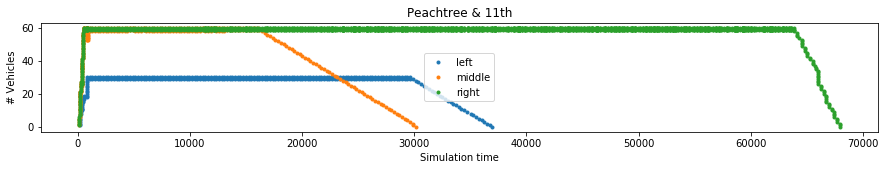

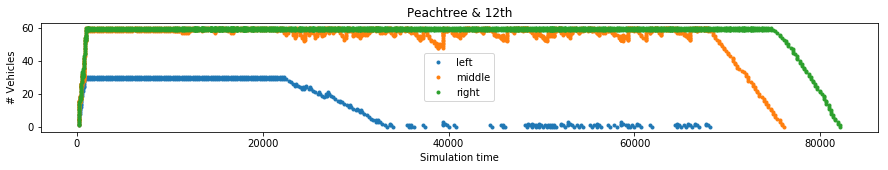

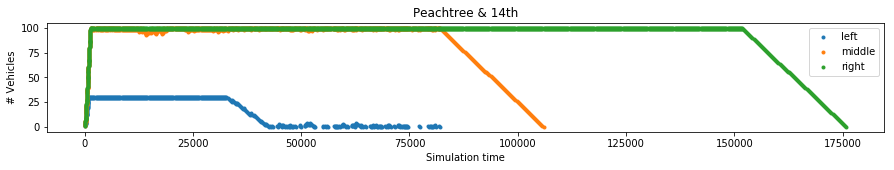

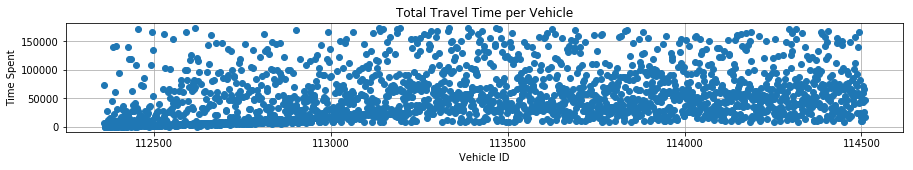

In [70]:
# PLOTS
lanes = ['left', 'middle', 'right']

plt.figure(figsize=(15,2))
plt.title('Peachtree & 11th')
for i in range(3):
    plt.plot(peachtree_and_11th.lanes[i].timestamps, peachtree_and_11th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.title('Peachtree & 12th')
for i in range(3):
    plt.plot(peachtree_and_12th.lanes[i].timestamps, peachtree_and_12th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.title('Peachtree & 14th')
for i in range(3):
    plt.plot(peachtree_and_14th.lanes[i].timestamps, peachtree_and_14th.lanes[i].history, '.', label=lanes[i])
plt.ylabel('# Vehicles')
plt.xlabel('Simulation time')
plt.legend()

plt.figure(figsize=(15,2))
plt.title('Total Travel Time per Vehicle')

plt.ylabel('Time Spent')
plt.xlabel('Vehicle ID')
plt.plot(vehicle_ids ,total_time, 'o')



plt.grid()

In [51]:
peachtree_and_14th.lanes[0].queue

deque([])

In [45]:
lane_13th_street.queue

deque([])

In [43]:
any(pending for pending in scheduler.notified.values())

False

In [12]:
scheduler.ident

140512545695488

In [46]:
scheduler.notified

{}

In [53]:
with peachtree_and_11th.lanes[0].cv:
    peachtree_and_11th.lanes[0].cv.notify()

In [54]:
list(map(lambda a: (a.f, a.time), scheduler.event_queue.queue))

[]

In [55]:
def test():
    return 1

scheduler.schedule(test, 0.1)

In [56]:
a = scheduler.event_queue.get()
(a.f, a.time)

(<function __main__.test()>, 118800.1)

In [57]:
scheduler.cv

<Condition(<unlocked _thread.RLock object owner=0 count=0 at 0x7fcb9c32ad80>, 0)>

In [19]:
with scheduler.cv:
    print(scheduler.cv)

<Condition(<locked _thread.RLock object owner=140513402709824 count=1 at 0x7fcba0bc72d0>, 0)>


In [20]:
scheduler.time

577

In [21]:
peachtree_and_11th.lanes[1].history

[1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 7,
 8,
 9,
 8,
 7,
 8,
 9,
 10,
 9,
 10,
 9,
 10,
 11,
 10,
 11,
 12,
 13,
 12,
 13,
 12,
 13,
 12,
 13,
 12,
 13,
 12,
 13,
 14,
 15,
 14,
 13,
 14,
 15,
 16,
 15,
 16,
 17,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 27,
 28,
 27,
 28]

In [47]:
import threading
threading.enumerate()

[<_MainThread(MainThread, started 140513402709824)>,
 <Thread(Thread-2, started daemon 140513232316160)>,
 <Heartbeat(Thread-3, started daemon 140513223923456)>,
 <HistorySavingThread(IPythonHistorySavingThread, started 140512992417536)>,
 <ParentPollerUnix(Thread-1, started daemon 140512984024832)>]

In [59]:
peachtree_and_11th.lanes[0].queue

deque([])

# peachtree_and_12th.lanes

In [ ]:
Lane.all_lanes_clear()